In [1]:
%config InlineBackend.figure_format = 'retina' # For mac users with Retina display
import yaml
import pymc3 as pm
import math
import arviz as az
import theano
import theano.tensor as tensor
import pandas as pd
from matplotlib import rc
from scipy import optimize
import corner as crn
import seaborn as sns
import pickle 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patches as mpl_patches
import pygtc
import json
######
import sys
sys.path.append('../HelpherFunctions/')
from Chi2 import *
from fancyspplot import *
## ***************************************************************************
## * RC param                                                                 *
## ***************************************************************************
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 22
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
## ***************************************************************************
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'monospace'
filename ="../results/data.yaml"
########
stream = open(filename, 'r')#
data = yaml.safe_load(stream)
#
colpastil = ['#9cadce','#937eba','#f09494','#72bbd0','#52b2cf','#ffafcc','#d3ab9e' ]
NBINS = 100
LambdaNP2 = 1e+3**2
v4 = 246.**4
v3 = 246.**3
mh2 = 125.1**2
sqrt_2 = np.sqrt(2.0)
def mode(x):
    """ Finds the mode of x
        argument:
            x: an array
    """
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def multimode(x, n, hdi_prob):
    """ Finds all the modes in the distribution
        arguments:
            x: the array for the distribution
            n: the identifier for the variable
    """
    md = az.hdi(x, hdi_prob=hdi_prob, multimodal=False)
    if len(md) < 2 and n > 1:
        return np.NaN
    else:
        return md[n%2]
    
def mode(x):
    # Function to find mode of an array x
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def minimize(likelihood, guess):
    """ Minimizing routine for finding global mode
    argument:
        likelihood: the likelihood function
        guess: the guess for the mode, [r, theta]
    """
    res = optimize.minimize(lambda x: -likelihood(x[0], x[1]), guess, method='BFGS', tol=1e-6)
    return res
unity = lambda x : x


def runMCMC1param(likelihood, limits, trace_dir='', config=[], fit=True):
    """ pyMC3 MCMC run
        argument:
            likelihood: the likelihood function
            limits: an array of the limits for the parameters [r_lowers, r_upper, theta_lower, theta_upper]
            trace_dir: the directory to which the MCMC traces are saves. '' implies none
            config: the setup for the MCMC. [MCMC smaple size, target_accept, chains]
            fit: bolean for determining whether to run the fit
        returns:
            trace: if fit is true it returns the trace
            model;if fit is false it returns the model
    """
    with pm.Model() as model:
        k1 = pm.Uniform('k1', lower=limits[0], upper=limits[1])
        like = pm.Potential('like', likelihood(k1))
        
    if fit:
        with model:
            trace = pm.sample(config[0], tune=int(np.max([1000,config[0]/5])), cores=4, target_accept=config[1], chains=config[2], init='advi_map')
#             print(az.summary(trace, round_to=5)) # Turn on to print summary
            if trace_dir != '': pm.save_trace(trace=trace, directory=trace_dir, overwrite=True)
        return trace, model
    return model

In [2]:
def plotdist(data,data2,filename,label, limit):
    stats_func_2 = {
        'b0': lambda x: multimode(x, 0, 0.9545),
        'b1': lambda x: multimode(x, 1, 0.9545),
        }
    var = ['k1']
    tr =data.get_values('k1', burn=100, combine=True)
    tr2 =data2.get_values('k1', burn=100, combine=True)
    colpastil = ['#9cadce','#937eba','#f09494','#72bbd0', '#ffcaaf' ,'#ffafcc','#d3ab9e' ]
    #fig, ax = plt.subplots(1, figsize=(8, 8))
    df_2 = pd.DataFrame(az.summary(data, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
    xup=df_2.loc['k1']['hdi_97.725%']
    xmu=[df_2.loc['k1']['mean']]
    xdown=df_2.loc['k1']['hdi_2.275%']
    print('run2')
    print(xup)
    print(xmu)
    print(xdown)
    df_22 = pd.DataFrame(az.summary(data2, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
    xup2=df_22.loc['k1']['hdi_97.725%']
    xmu2=[df_22.loc['k1']['mean']]
    xdown2=df_22.loc['k1']['hdi_2.275%']
    print('HL-LHC')
    print(xup2)
    print(xmu2)
    print(xdown2)


    #az.plot_posterior(data, var_names=['k1'], hdi_prob=.95,color=colpastil[2],ax=ax)
    #az.plot_posterior(data, var_names=['k1'], hdi_prob=.95)
    GTC = pygtc.plotGTC(chains=[np.array([tr]).T,np.array([tr2]).T],
                    paramNames=r'label',
                    chainLabels=['LHC Run-II','HL-LHC'],
                    truths=[0.],
                    customLegendFont={'family':'serf', 'size':28},
                    truthLabels='',
                    colorsOrder=['blues_old','reds_old'],
                    figureSize='APJ_page',
                    doOnly1dPlot=True,
                    filledPlots=False)

    for ax in GTC.get_axes():
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='both', direction='in')
        ax.tick_params(axis='x',  which='both',direction='in')
        ax.tick_params(axis='y', which='minor', top=True, size= 5)
        ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax.tick_params(axis='y', which='major', labelsize=26, rotation=0,top=True,size=10 )
        ax.tick_params(axis='x',  which='major',labelsize=26, rotation=0,right=True,size=10 )
    ax =GTC.get_axes()
    ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off)
      )
    ax[0].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    ax[0].set_xlabel(label+r"$\,[\mathrm{TeV}^{-2}]$",fontsize= 28)
    ax[0].set_ylabel(r"Posterior",fontsize= 28)
    ax[0].axvspan(xup,xdown, alpha=0.2, color='gray',label=r'95\% CI')   
    #plt.text(-0.2,50,text,fontsize=24)
   #plt.xlim(limits[0],limits[1])
    #plt.ylim(limits[2],limits[3])
    #plt.title('%f'%((xup-xdown)/2.),fontsize= 28)
    plt.tight_layout()
    GTC.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    return  pd.DataFrame({'operator':label, 
                          'mu':{'run2':xmu,'hl':xmu2},
                          'up':{'run2':xup,'hl':xup2},
                          'low':{'run2':xdown,'hl':xdown2}})

## $C_\phi$ linear

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 200
Interrupted at 199 [0%]: Average Loss = 11.919
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 4100
Interrupted at 4,099 [2%]: Average Loss = 2.63
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 32 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
1.5365590367699016
[-10.151058959539508]
-21.787852488545283
HL-LHC
6.1086325944233675
[-0.026975342461909295]
-6.218432679574789


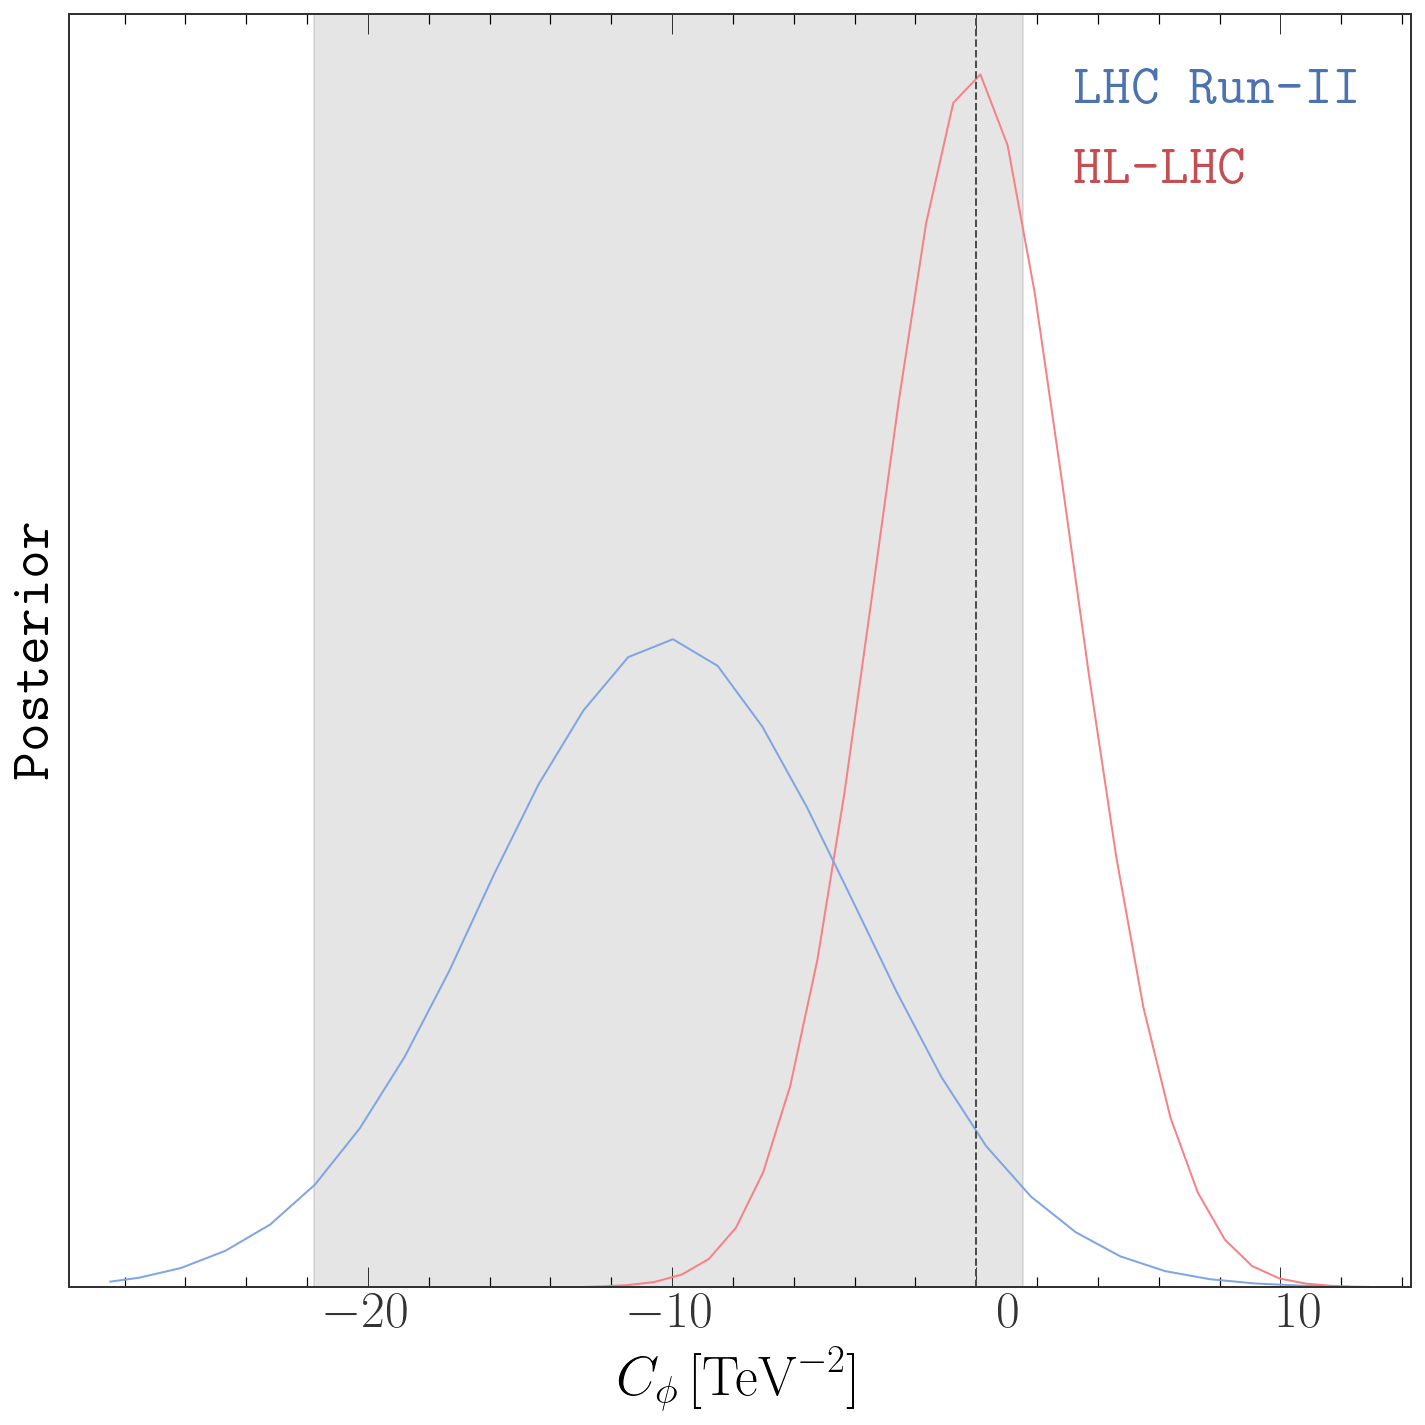

In [3]:
llCqtm =lambda CH :mylikelihood('Cqtqb8',0.0,CH,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh'],mode='fin'
                                                                           ,TopChannels=None,l3mode='linear',linearmu=True) 


llCqtq =lambda CH :mylikelihood('Cqtqb8',0.0,CH,data,experiments=['HL-LHC'],
                                                                           HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc'],mode='fin'
                                                                           ,TopChannels=None,l3mode='linear',linearmu=True) 

limits = [-30, 20]
config = [15000, 0.8, 5]

trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config)
df_cphi_linear=plotdist(trace_1,trace_2,'../results/plots/single_param/Cphi-linear-fin.pdf','$C_\phi$' ,limits)

In [4]:
run2
-0.7220430781690996
[-12.981418884704478]
-25.047295216879686
HL-LHC
6.358723638078866
[0.010191821757746725]
-6.032559390307673
run2
1.9347731091657978
[-9.613928600801284]
-21.128559405535814
HL-LHC
6.253994386617045
[0.018826658162848273]
-6.150553323972925

NameError: name 'run2' is not defined

## $C_\phi$ quadratic

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 400
Interrupted at 399 [0%]: Average Loss = 12.715
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 4200
Interrupted at 4,199 [2%]: Average Loss = 2.7101
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 86 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
2.3896528341210965
[-6.565107148045697]
-15.734405908281353
HL-LHC
5.172572508372523
[-0.894870573089123]
-7.927843778211603


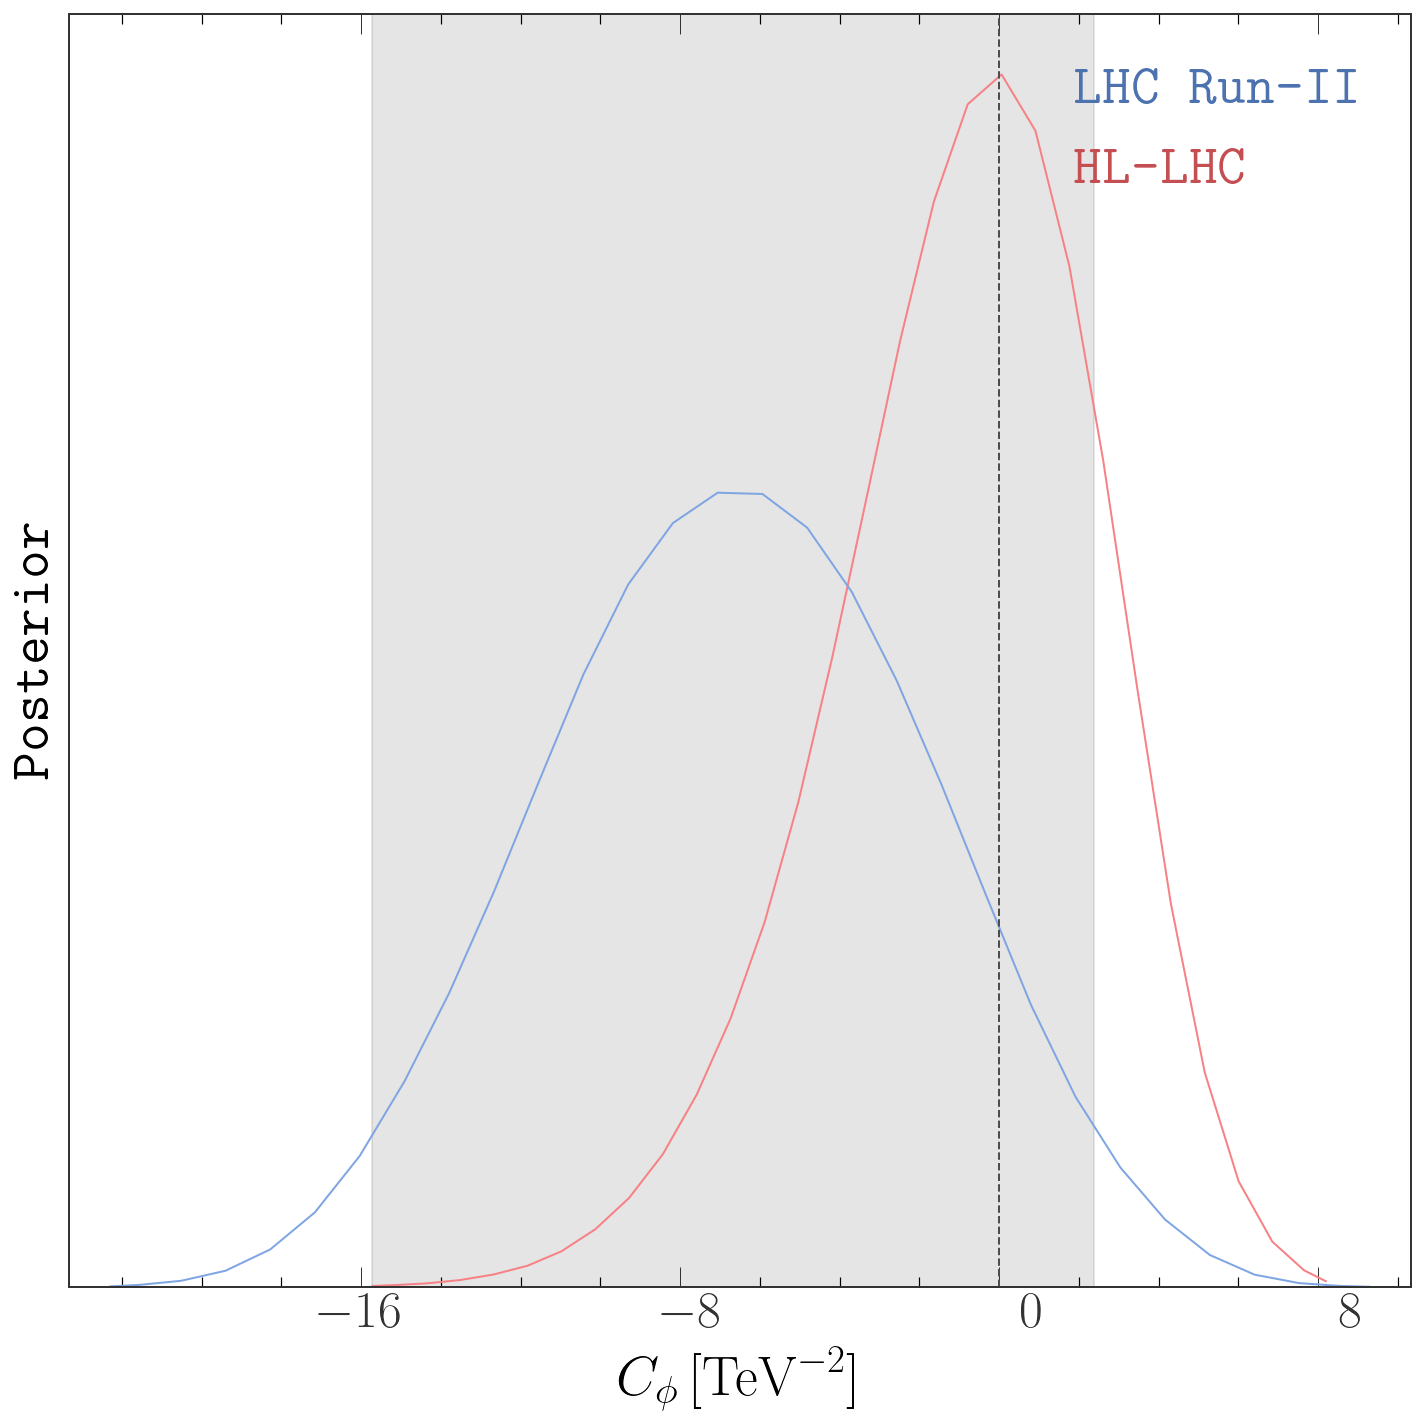

In [6]:
llCqtm =lambda CH :mylikelihood('Cqtqb8',0.0,CH,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh']
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 


llCqtq =lambda CH :mylikelihood('Cqtqb8',0.0,CH,data,experiments=['HL-LHC'],
                                                                           HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc']
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 

limits = [-30, 20]
config = [15000, 0.8, 5]

trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config)
df_cphi_quad=plotdist(trace_1,trace_2,'../results/plots/single_param/Cphi-quadratic.pdf','$C_\phi$' ,limits)

## $C_{Qt}^{(1)}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 5900
Interrupted at 5,899 [2%]: Average Loss = 14.846
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 5100
Interrupted at 5,099 [2%]: Average Loss = 15.542
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 22 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
0.3714497677181616
[-0.22670400069107524]
-0.8473935991941932
HL-LHC
0.6379562375074159
[0.12643439623132227]
-0.4089092304432973


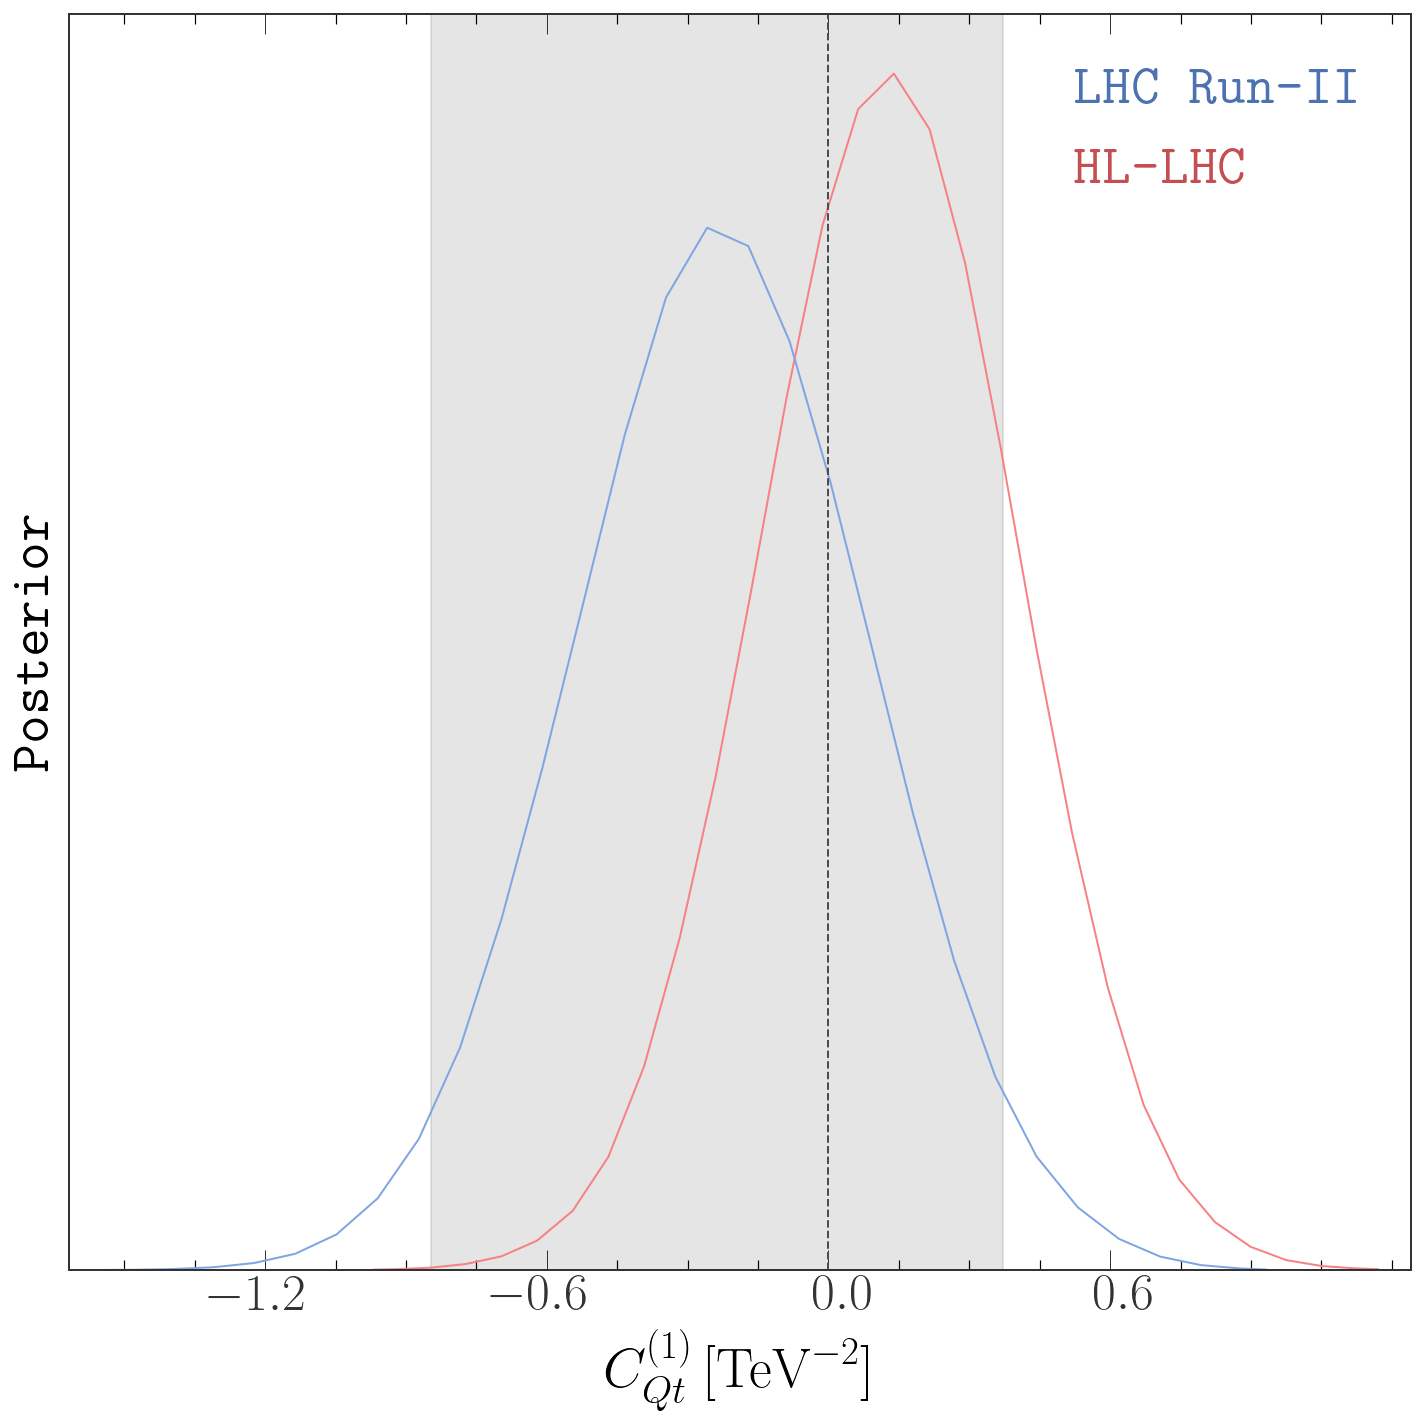

In [5]:
llCqtm =lambda CH :mylikelihood('Cqt1',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh'],mode='rge'
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 

llCqtq =lambda CH :mylikelihood('Cqt1',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh'],mode='rge'
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=False) 
#llCqtq =lambda CH :mylikelihood('Cqt1',CH,0.0,data,experiments=['HL-LHC'],
  #                                                                         HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc'],mode='rge'
#                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 

limits = [-3, 3]
config = [15000, 0.8, 5]

trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config)
df_cqt1=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqt1.pdf','$C_{Qt}^{(1)}$' ,limits)

In [8]:
0.200867496031372
[-0.45596850129420463]
-1.1219228592855621
HL-LHC
0.38001776177483493
[-0.2194894075623984]
-0.8352037733190651

0.3714497677181616
[-0.22670400069107524]
-0.8473935991941932
HL-LHC
0.6379562375074159
[0.12643439623132227]
-0.4089092304432973

0.04238310333747949


## $C_{Qt}^{(8)}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 2600
Interrupted at 2,599 [1%]: Average Loss = 13.784
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 27 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 3500
Interrupted at 3,499 [1%]: Average Loss = 13.764
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 22 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
4.054623065962087
[0.9981430444424735]
-2.1541114223810713
HL-LHC
1.9121952796949455
[-0.7734023921784368]
-3.485975086602901


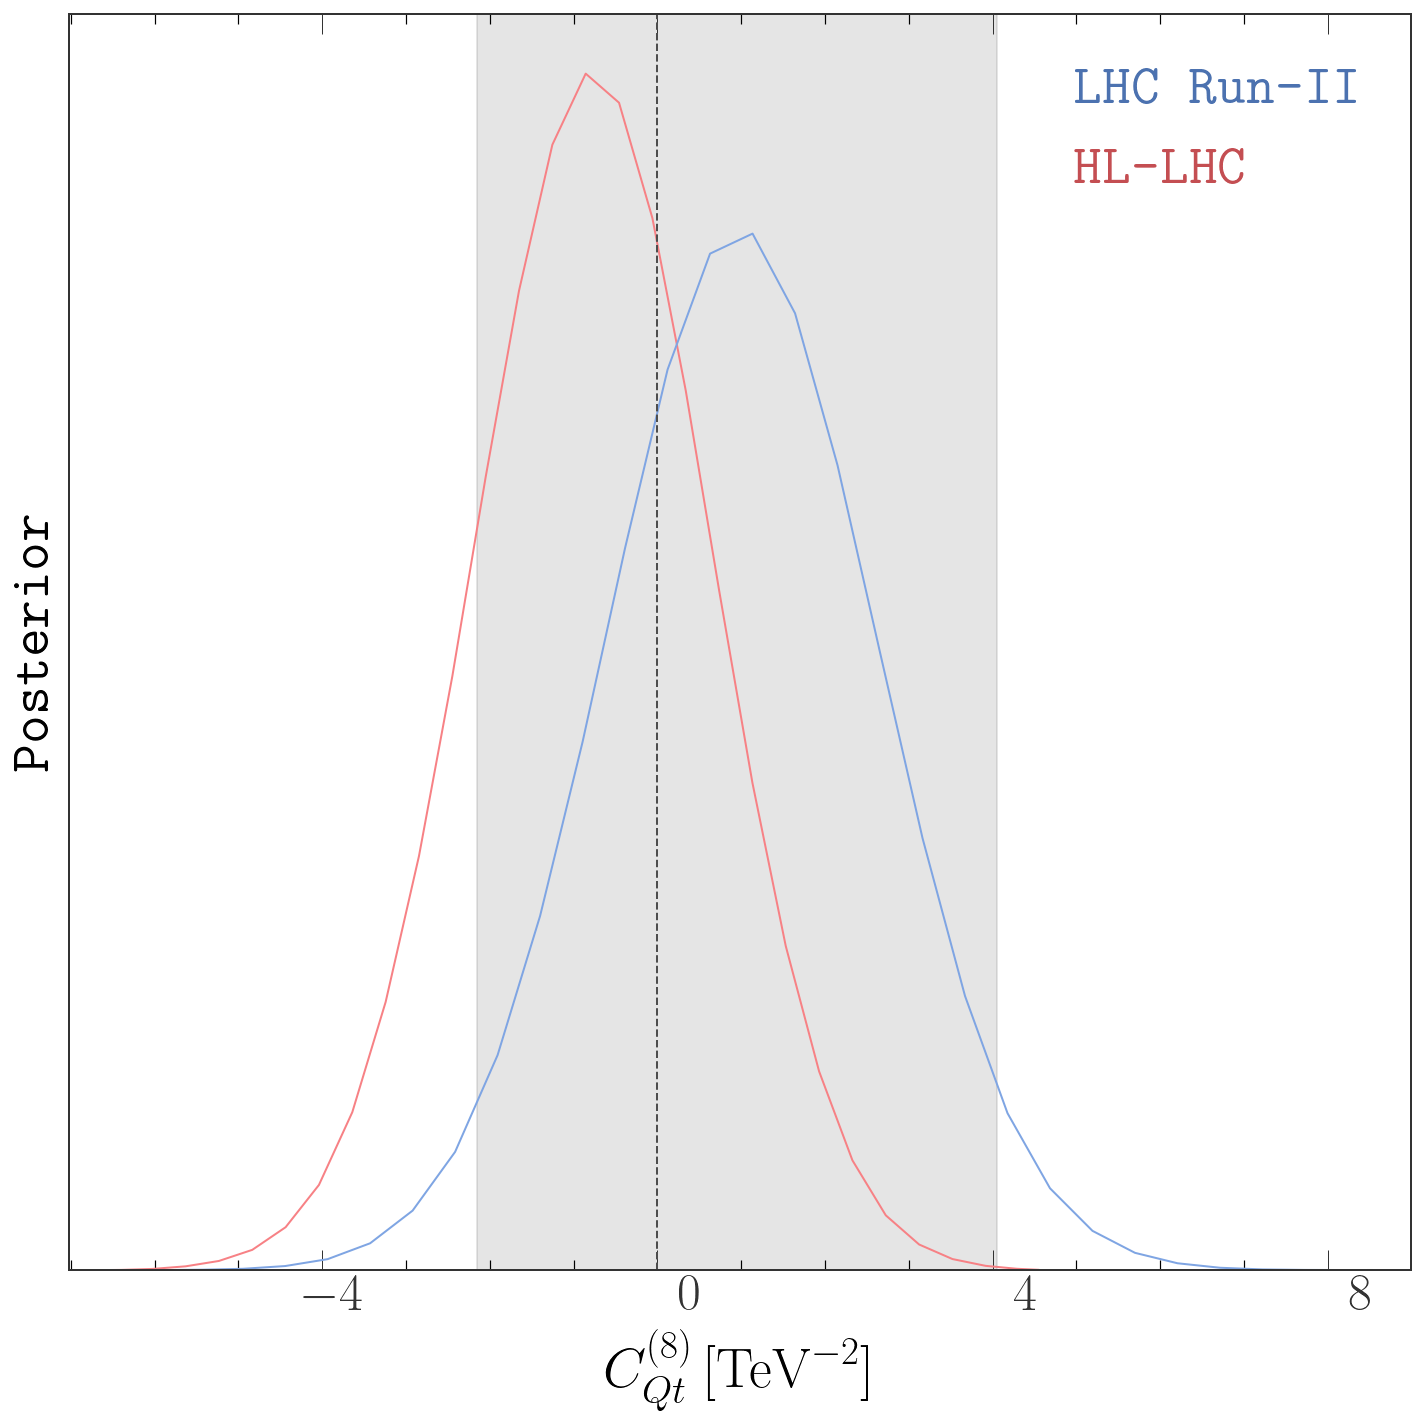

In [7]:
llCqtm =lambda CH :mylikelihood('Cqt8',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh'],mode='rge'
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 


llCqtq =lambda CH :mylikelihood('Cqt8',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh'],mode='rge'
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=False) 
#llCqtq =lambda CH :mylikelihood('Cqt8',CH,0.0,data,experiments=['HL-LHC'],
 #                                                                          HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc'],mode='rge'
  #                                                                         ,TopChannels=None,l3mode='quadratic',linearmu=True) 

limits = [-10, 10]
config = [15000, 0.8, 5]

trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config)
df_cqt8=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqt8.pdf','$C_{Qt}^{(8)}$' ,limits)

In [12]:
a =(5.61534047095539+1.169270552503221)/2

b=(4.124722161448801+2.100461439979689)/2

print((a-b)/(a))

0.08245534196372242


## $C_{QtQb}^{(1)}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 7800
Interrupted at 7,799 [3%]: Average Loss = 20.177
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 8000
Interrupted at 7,999 [3%]: Average Loss = 23.811
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 22 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
0.3694345604309252
[0.15449740191754796]
-0.06420715281966083
HL-LHC
0.29216869894655645
[0.0931437125350888]
-0.10628445812920742


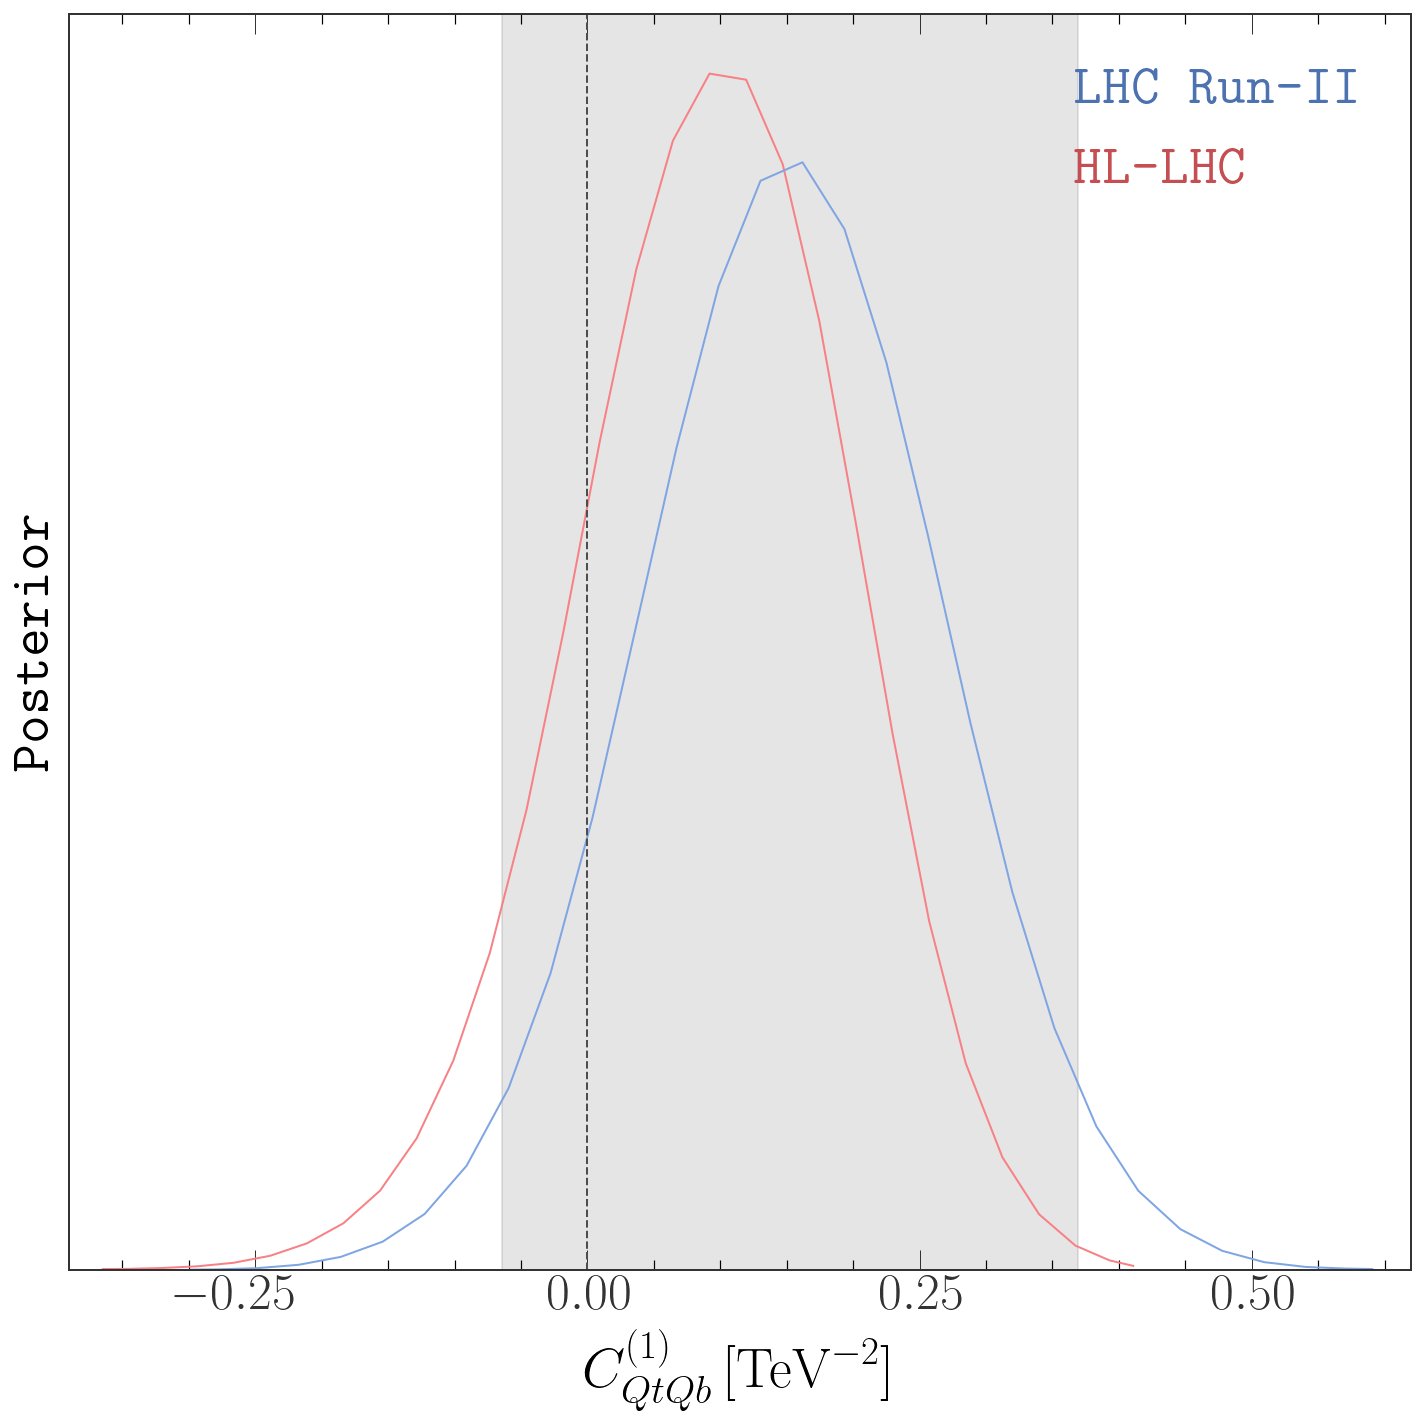

In [5]:
llCqtm =lambda CH :mylikelihood('Cqtqb1',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh'],mode='rge'
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 


llCqtq =lambda CH :mylikelihood('Cqtqb1',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh'],mode='rge'
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=False) 

#llCqtq =lambda CH :mylikelihood('Cqtqb1',CH,0.0,data,experiments=['HL-LHC'],
 #                                                                          HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc'],mode='rge'
  #                                                                         ,TopChannels=None,l3mode='quadratic',linearmu=True) 

limits = [-2.2, 2.2]
config = [15000, 0.8, 5]

trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config)
df_cqtqb1=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqtqb1.pdf','$C_{QtQb}^{(1)}$' ,limits)

In [14]:
HL-LHC
0.28083441684171045
[0.08534299834338276]
-0.12084514432805067
0.29216869894655645
[0.0931437125350888]
-0.10628445812920742

0.04908938411929157


## $C_{QtQb}^{(8)}$

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 3900
Interrupted at 3,899 [1%]: Average Loss = 14.173
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 8100
Interrupted at 8,099 [4%]: Average Loss = 5.649
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [k1]


Sampling 5 chains for 3_000 tune and 15_000 draw iterations (15_000 + 75_000 draws total) took 38 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


run2
1.9186147525767856
[0.7654084630246871]
-0.3324712530707544
HL-LHC
0.6938639845916851
[0.002459566162572554]
-0.6557595108647791


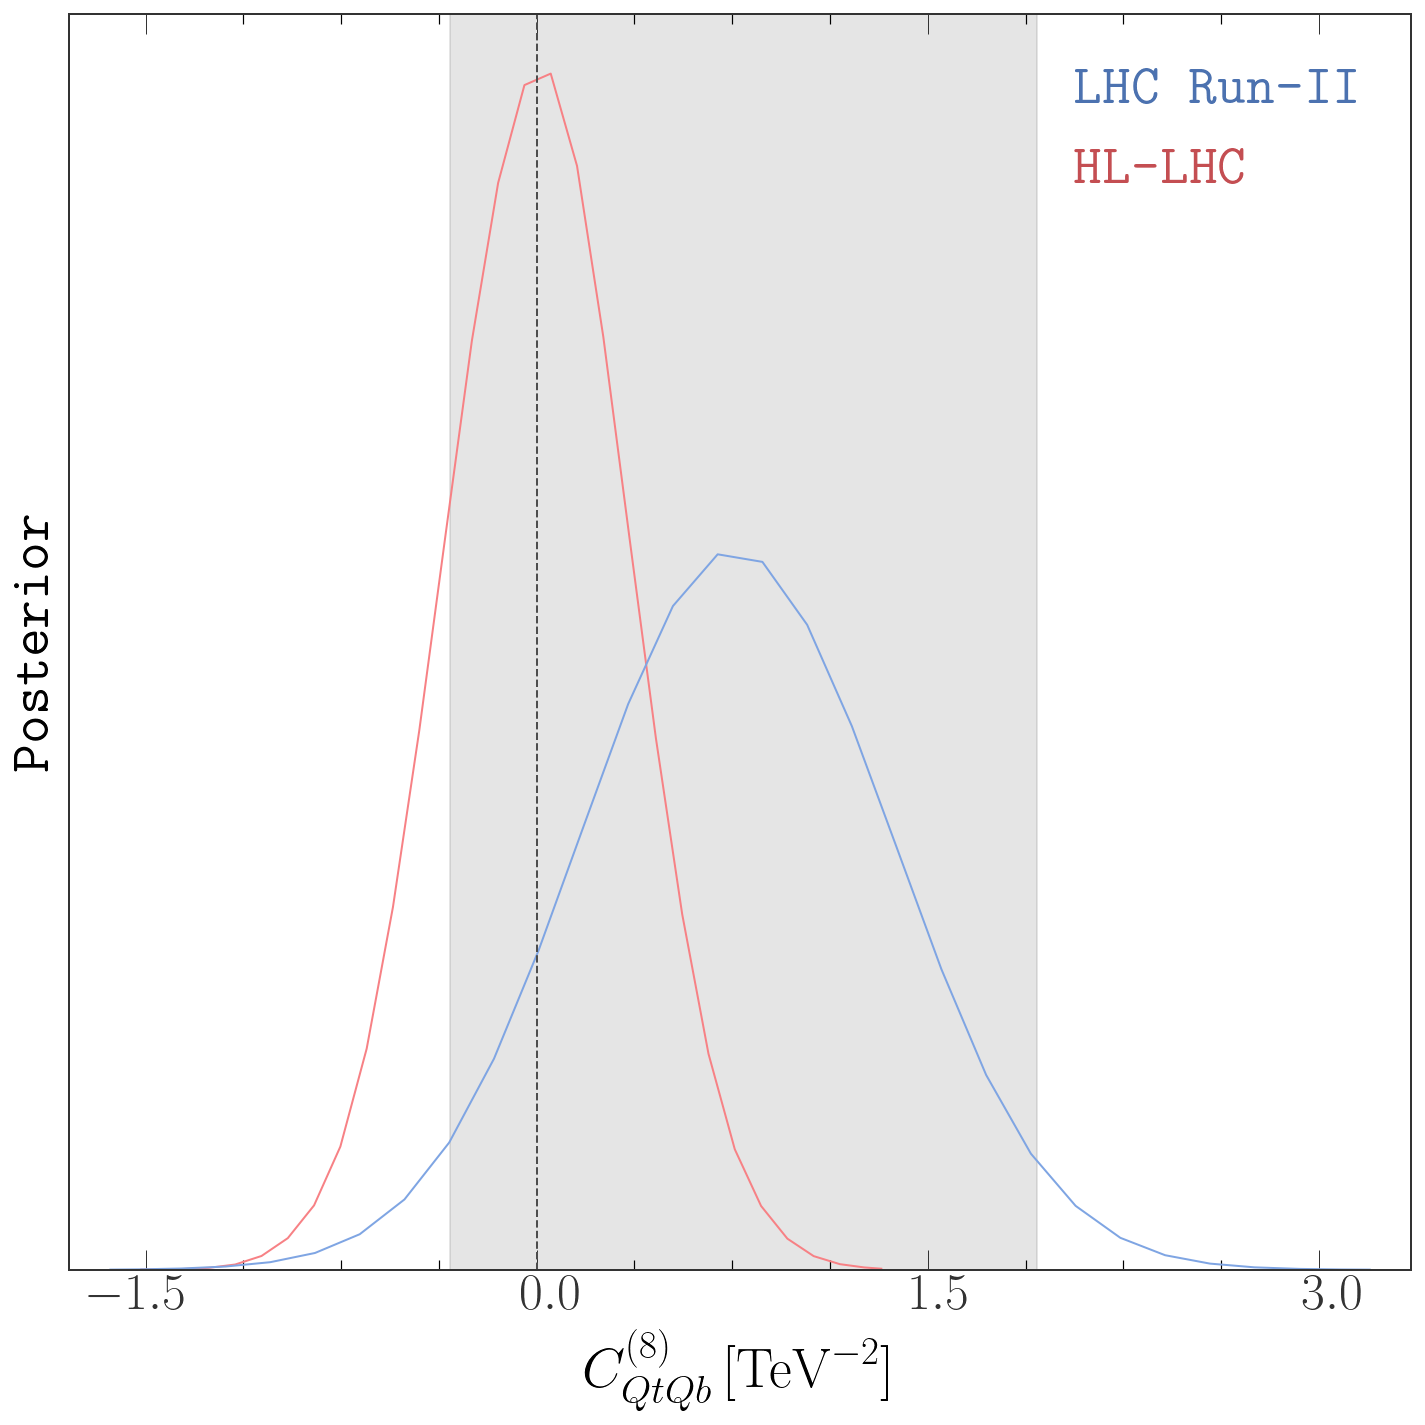

In [9]:
llCqtm =lambda CH :mylikelihood('Cqtqb8',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh'],mode='rge'
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 


llCqtq =lambda CH :mylikelihood('Cqtqb8',CH,0.0,data,experiments=['HL-LHC'],
                                                                           HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc'],mode='rge'
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 

limits = [-5.25, 5.25]
config = [15000, 0.8, 5]

trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config)
df_cqtqb8=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqtqb8.pdf','$C_{QtQb}^{(8)}$' ,limits)

## $C_{tt}^{(1)}$

In [9]:
llCqtm =lambda CH :mylikelihood('Ctt1',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh']
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 


llCqtq =lambda CH :mylikelihood('Ctt1',CH,0.0,data,experiments=['HL-LHC'],
                                                                           HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc']
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 

limits = [-60, 60]#
config = [15000, 0.8, 5]

trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config)
df_ctt=plotdist(trace_1,trace_2,'../results/plots/single_param/Ctt.pdf','$C_{tt}$' ,limits)

KeyError: 'htogg_fin'

In [ ]:
llCqtm =lambda CH :mylikelihood('Cqq1',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh']
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 


llCqtq =lambda CH :mylikelihood('Cqq1',CH,0.0,data,experiments=['HL-LHC'],
                                                                           HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc']
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 

limits = [-60, 150]
config = [15000, 0.8, 5]

trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config)
df_ctt=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqq1.pdf','$C_{QQ}^{(1)}$' ,limits)

In [ ]:
llCqtm =lambda CH :mylikelihood('Cqq8',CH,0.0,data,experiments=['ATLAS','CMS'],HiggsChannels=['ggf','vbf','ttxh','vh','wh','zh']
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 


llCqtq =lambda CH :mylikelihood('Cqq8',CH,0.0,data,experiments=['HL-LHC'],
                                                                           HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc']
                                                                           ,TopChannels=None,l3mode='quadratic',linearmu=True) 

limits = [-60, 160]
config = [15000, 0.8, 5]

trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
trace_2, model_2 = runMCMC1param(llCqtq, limits, config=config)
df_ctt=plotdist(trace_1,trace_2,'../results/plots/single_param/Cqq8.pdf','$C_{QQ}^{(8)}$' ,limits)

In [13]:
getrun2 = lambda xdf: 1/((xdf["up"]["run2"]-xdf["low"]["run2"])/2.)**0.5
gethl= lambda xdf: 1/((xdf["up"]["hl"]-xdf["low"]["hl"])/2.)**0.5
df = pd.DataFrame({"index":[0,1,2,3,4,5,6]
                   ,"wilson_coef":["cphiL","cphiQ","cphihh","cqt8","cqt1","cqtqb8","cqtqb1"]
                   ,"runtwo":[getrun2(df_cphi_linear),getrun2(df_cphi_quad),0.34,getrun2(df_cqt8),getrun2(df_cqt1),getrun2(df_cqtqb8),getrun2(df_cqtqb1)]
                   , "hightlum":[gethl(df_cphi_linear),gethl(df_cphi_quad),0.87,gethl(df_cqt8),gethl(df_cqt1),gethl(df_cqtqb8),gethl(df_cqtqb1)]
                  })
df.to_csv(r'../results/single_fit_HL-LHC14.csv')
df

,index,wilson_coef,runtwo,hightlum
0,0,cphiL,0.286739,0.401751
1,1,cphiQ,0.332640,0.390087
2,2,cphihh,0.340000,0.870000
3,3,cqt8,0.544459,0.847920
4,4,cqt1,1.227486,1.857186
5,5,cqtqb8,0.253380,0.350097
6,6,cqtqb1,0.567343,0.808296


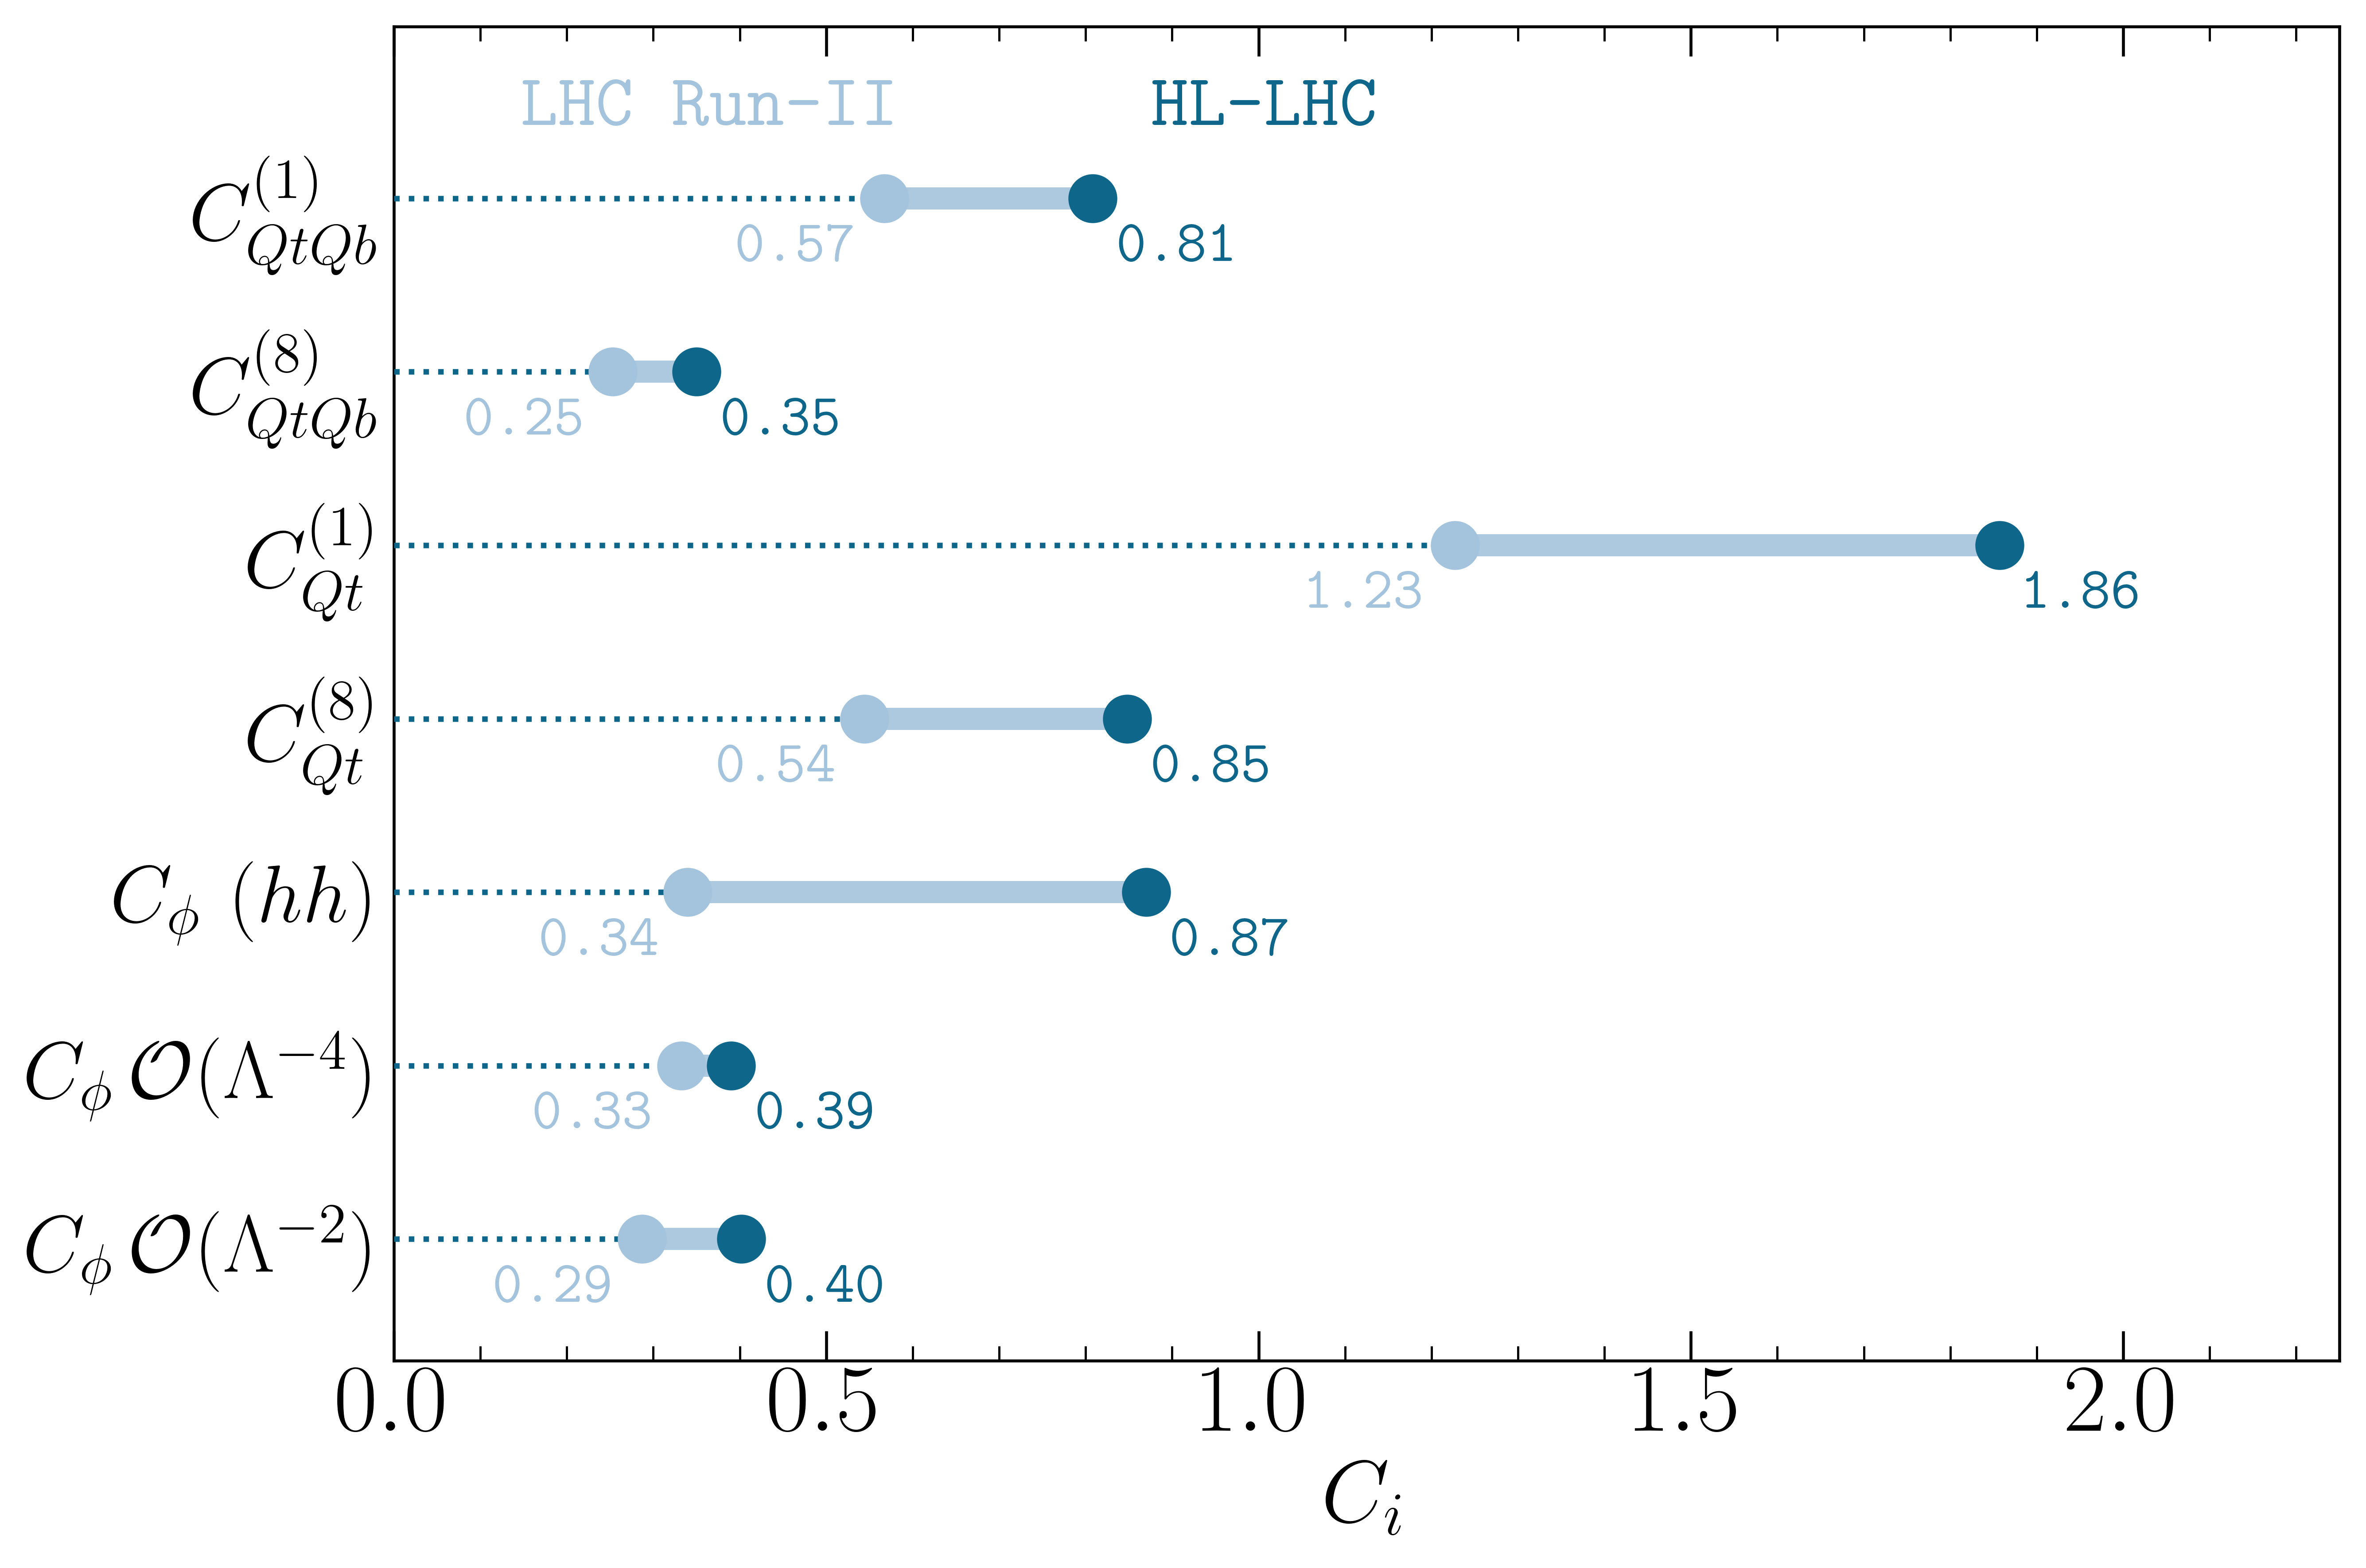

In [22]:
import matplotlib.lines as mlines
#
col1='#a3c4dc' # light
col2='#0e668b' # dark

#col1='#9dd4d7' # light
#col2='#006f71' # dark
# Import Data
df = pd.read_csv("../results/single_fit_HL-LHC14.csv")

# Func to draw line segment
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], lw= 6,color=col1, alpha= 0.9)
    ax.add_line(l)
    return l

# Figure and Axes
fig, ax = plt.subplots(1,1,figsize=(9,6), dpi= 300)

# Vertical Lines
#ax.vlines(x=.05, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
#ax.vlines(x=.10, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
#ax.vlines(x=.15, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')
#ax.vlines(x=.20, ymin=0, ymax=26, color='black', alpha=1, linewidth=1, linestyles='dotted')

# Points
ax.scatter(y=df['index'], x=df['runtwo'], s=150, color=col1, alpha=1,zorder=12)
for i, p1, p2 in zip(df['index'], df['runtwo'], df['hightlum']):
    newline([p1, i], [p2, i])
    plt.hlines(i,0.0,p1,color=col2, ls=':',zorder=10)
ax.scatter(y=df['index'], x=df['hightlum'], s=150, color=col2, alpha=1, zorder= 9)


for x, y, tex in zip(df['runtwo'], df['index'], df['runtwo']):
    if y==6:
        plt.text(x-0.2, y+0.5, r'LHC Run-II', horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':col1,'size':20})       
    t = plt.text(x-0.1, y-0.3,"{:1.2f}".format(tex), horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':col1,'size':16})

for x, y, tex in zip(df['hightlum'], df['index'], df['hightlum']):
    if y==6:
        plt.text(x+0.2, y+0.5, r'HL-LHC', horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':col2,'size':20})     
    t = plt.text(x+0.1, y-0.3, "{:1.2f}".format(tex), horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':col2,'size':16})
    
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off)
    size=4
         ) 
#ax.set_title("Dumbell Chart: Pct Change - 2013 vs 2014", fontdict={'size':22})
ax.get_xaxis().set_minor_locator(AutoMinorLocator())
ax.set_yticklabels(['',r'$C_{\phi}\,\mathcal{O}(\Lambda^{-2})$',r'$C_{\phi}\, \mathcal{O}(\Lambda^{-4})$',r'$C_{\phi}\,\,(hh)$',\
                   r'$C_{Qt}^{(8)}$',r'$C_{Qt}^{(1)}$',\
                   r'$C_{QtQb}^{(8)}$',r'$C_{QtQb}^{(1)}$'])
ax.set_xlabel(r"$C_i$", fontsize=24)
ax.set(ylim=(-0.7, 6.99), xlim=(-0.0,2.25))
#ax.set(ylim=(-0.7, 6.99), xlim=(-0.0,13))
#plt.text(2.25,2.5,r'Single param. fit', fontsize=20)
#plt.text(2.5,2,r'$95\%$ CI', fontsize=20)
plt.tight_layout()
#plt.gca().invert_yaxis()

plt.savefig('../results/plots/HL-LHC_reachWC.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [10]:
run2 =np.array([ (+0.919+25.28)/2.0 , (1.422+16.5684)/2,(0.22+1.06)/2.,(6.65+1.159)/2.,(0.199+0.031)/2.])
np.log10(run2)

array([ 1.11725472,  0.95401082, -0.19382003,  0.59156543, -0.93930216])

[3.11725472 2.95401082 1.80617997 2.59156543 1.06069784 1.90194847
 3.515946   3.88860908 3.54950597]
[2.7863716  2.81693694 1.45331834 2.22310638 0.98677173 1.69178852
 3.2824737  3.4530889  3.54828498]


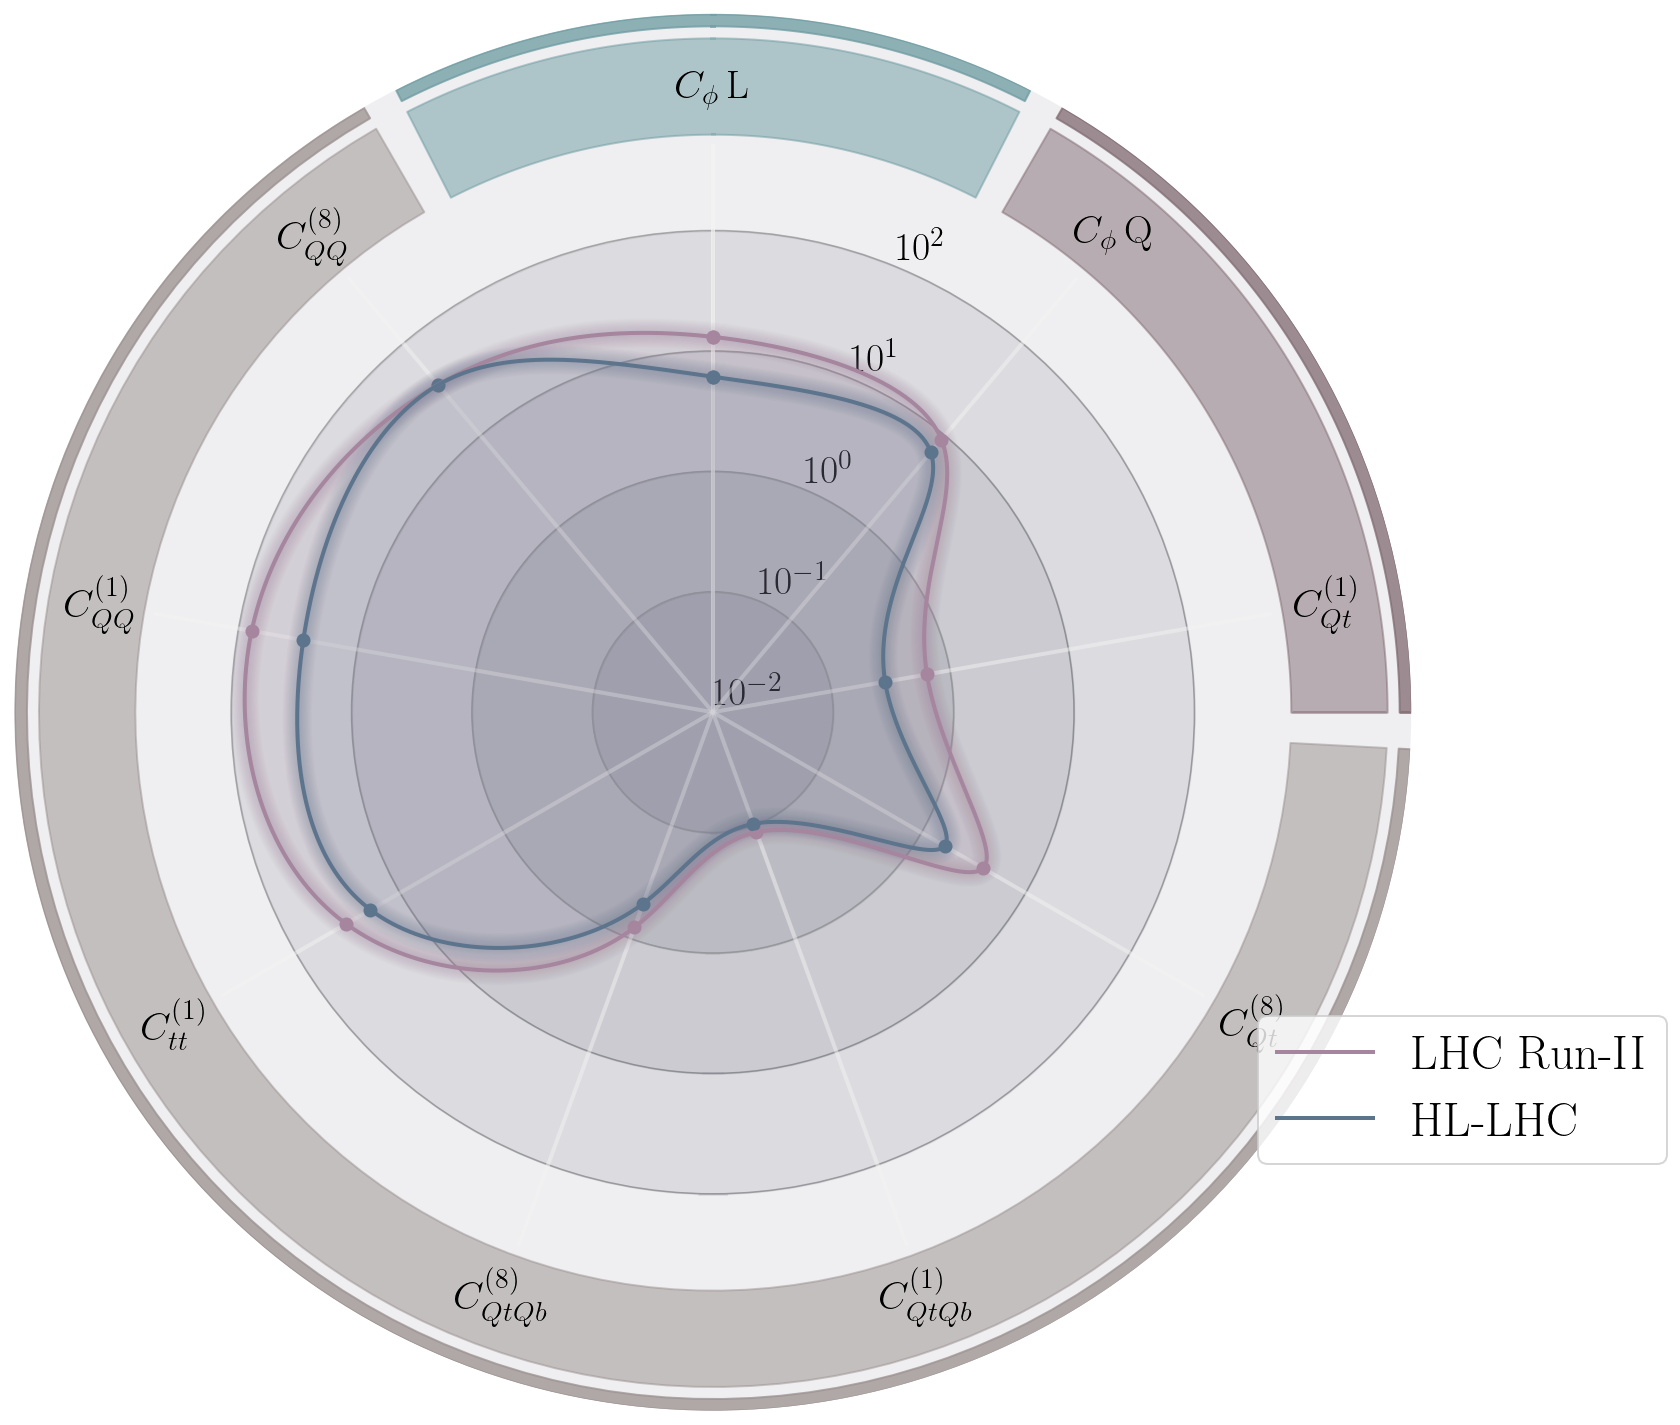

In [3]:

run2 =np.array([ (+0.919+25.28)/2.0 , (1.422+16.5684)/2,(0.22+1.06)/2.,(6.65+1.159)/2.,(0.199+0.031)/2.,
                (1.3428+0.253)/2.,(58.051+7.5599)/2,(133.013+21.74)/2,( 89.28+-18.398)/2 ])
hl=np.array([(6.0423+6.187)/2.0,(5.189+7.932)/2.0, (0.278+0.290)/2.,(1.70+1.643)/2,(0.097+0.097)/2., 
             (0.4846+0.4990)/2.,(18.6169+19.71)/2 ,(28.18+28.59)/2, (35.588+35.095)/2] )

run2=2+np.log10(run2)
print(run2)
hl=2+np.log10(hl)
print(hl)
labs=[r'$C_{\phi}\,\mathrm{L}$',r'$C_{\phi}\,\mathrm{Q}$',\
                   r'$C_{Qt}^{(1)}$',r'$C_{Qt}^{(8)}$',\
                   r'$C_{QtQb}^{(1)}$',r'$C_{QtQb}^{(8)}$',r'$C_{tt}^{(1)}$'\
      , r'$C_{QQ}^{(1)}$',r'$C_{QQ}^{(8)}$'
     ]
plt.figure(figsize=(14,10))
plt.rcParams["axes.axisbelow"] = False
ax = plt.subplot(polar=True)
plt.rcParams['xtick.labelsize'] = 24
ax =FancySpiderPlot(ax,data=[run2,hl],
                    yticks=[0,1,2,3,4],
                    ytickslabels=[r"$10^{-2}$",r"$10^{-1}$",r"$10^{0}$",r"$10^{1}$",r"$10^{2}$"],
                    ylim=(0,5.8),
                   # facecolor=('#e5e6dd','#dbdcda'),
                    colors=['#a6859e','#5d748d'],
                    DataLabels=[r"LHC Run-II",r"HL-LHC"],
                    XaxisLabels=labs,
                    XaxisPad=-45)
######################
##decor 
#####################
ax.fill_between(
    np.linspace(-27/180*np.pi, +27/180*np.pi, 100),
    5.7,
    5.8,
    alpha=0.75,
    color='#6d9ba1', zorder= -4
)
ax.fill_between(
    np.linspace(-27/180*np.pi, +27/180*np.pi, 100), 
    4.8,
    5.6,
    alpha=0.5,
    color='#6d9ba1', zorder= -4
)
ax.fill_between(
    np.linspace(30/180*np.pi, +90/180*np.pi, 100), 
    5.7,
    5.8,
    alpha=0.75,
    color='#816b72', zorder= -4
)
ax.fill_between(
    np.linspace(30/180*np.pi, +90/180*np.pi, 100), 
    4.8,
    5.6,
    alpha=0.5,
    color='#816b72', zorder= -4
)
ax.fill_between(
    np.linspace(93/180*np.pi, +330/180*np.pi, 100), 
    5.7,
    5.8,
    alpha=0.75,
    color='#9a908f', zorder= -4
)
ax.fill_between(
    np.linspace(93/180*np.pi, +330/180*np.pi, 100), 
    4.8,
    5.6,
    alpha=0.5,
    color='#9a908f', zorder= -4
)

##########################
ax.legend(bbox_to_anchor=(1.2, 0.3),fontsize=24)
plt.tight_layout()
plt.show()

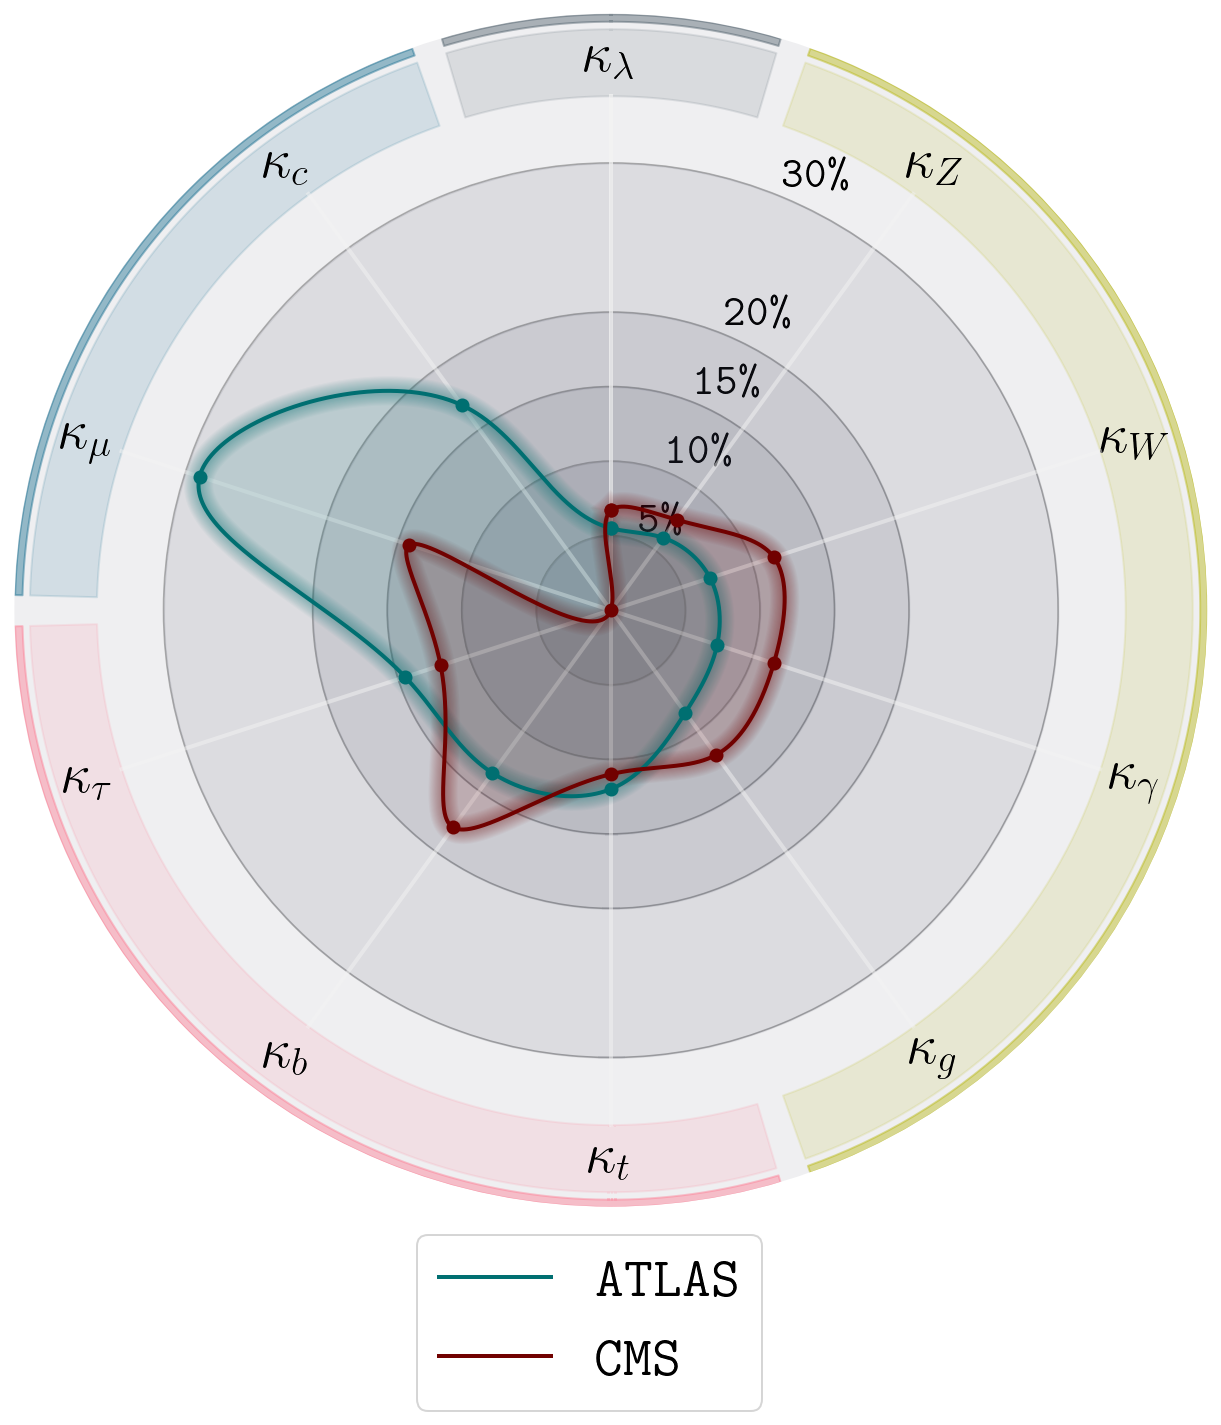

In [35]:
plt.rcParams['xtick.labelsize'] = 28
labs=[r'$\kappa_\lambda$',r'$\kappa_Z$',r'$\kappa_W$',
      r'$\kappa_\gamma$',r'$\kappa_g$',r'$\kappa_t$',
      r'$\kappa_b$',r'$\kappa_\tau$',r'$\kappa_\mu$',
      r'$\kappa_c$'\
     ]
ATLAS =np.array(
        [
      .055, #100
       .06,.07, .075, .085, .12,.135,.145,.29,.17 #*5
    ]
)


CMS =np.array(
    [
    .067,#100
      .075,.115,.115,.12,.11,.18,.12,.142, #*5
     0.0
    ]
)
plt.figure(figsize=(14,10))
plt.rcParams["axes.axisbelow"] = False
ax = plt.subplot(polar=True)
plt.rcParams['xtick.labelsize'] = 24
ax =FancySpiderPlot(ax,data=[ATLAS*100,CMS*100],
                    yticks=[0,5,10,15,20,30],
                    ytickslabels=[r"",r"5\%",r"10\%",r"15\%",r"20\%",r"30\%"],
                    ylim=(0,40),
                   # facecolor=('#e5e6dd','#dbdcda'),
                    #colors=['#a6859e','#5d748d'],
                    DataLabels=[r"ATLAS",r"CMS"],
                    XaxisLabels=labs,
                    XaxisPad=-30,
                   gridpad=5.5)
######################
##decor 
#####################
a= 36/2
d= (1.5)/180*np.pi
ax.fill_between(
    np.linspace(-a/180*np.pi+d, +a/180*np.pi-d, 100),
    39.5,
    40,
    alpha=0.4,
    color='#40525e', zorder= -4
)
ax.fill_between(
    np.linspace(-a/180*np.pi+d, +a/180*np.pi-d, 100),
    34.5,
    39.,
    alpha=0.125,
    color='#40525e', zorder= -4
)
######
ax.fill_between(
    np.linspace(a/180*np.pi+d, +9*a/180*np.pi-d, 100),
    39.5,
    40,
    alpha=0.4,
    color='#b3b300', zorder= -4
)
ax.fill_between(
    np.linspace(a/180*np.pi+d, +9*a/180*np.pi-d, 100),
    34.5,
    39.,
    alpha=0.125,
    color='#b3b300', zorder= -4
)
######
ax.fill_between(
    np.linspace(9*a/180*np.pi+d, +15*a/180*np.pi-d, 100),
    39.5,
    40,
    alpha=0.4,
    color='#ff748c', zorder= -4
)
ax.fill_between(
    np.linspace(9*a/180*np.pi+d, +15*a/180*np.pi-d, 100),
    34.5,
    39.,
    alpha=0.125,
    color='#ff748c', zorder= -4
)
######
ax.fill_between(
    np.linspace(15*a/180*np.pi+d, 19*a/180*np.pi-d, 100),
    39.5,
    40,
    alpha=0.4,
    color='#0a668a', zorder= -4
)
ax.fill_between(
    np.linspace(15*a/180*np.pi+d, 19*a/180*np.pi-d, 100),
    34.5,
    39.,
    alpha=0.125,
    color='#0a668a', zorder= -4
)
##########################
ax.legend(bbox_to_anchor=(.65, 0.),fontsize=28)
plt.tight_layout()
plt.savefig('./Higgs_couplings_poster.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()